## Package Import

In [ ]:
#GP, LSTM
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.statespace.sarimax import SARIMAX

from itertools import product

from tqdm import tqdm_notebook

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Import and Preview

In [ ]:
raw_cal = pd.read_csv('drive/MyDrive/calendar.csv')
raw_cal.shape

(1969, 14)

In [ ]:
raw_sales = pd.read_csv('drive/MyDrive/sales_train_evaluation.csv')
raw_sales.shape

(30490, 1947)

In [ ]:
raw_cal["event_name_1"].value_counts() #the category of events and its counts in the column event_name_1

SuperBowl              6
Pesach End             6
Ramadan starts         6
ValentinesDay          6
NBAFinalsEnd           6
NBAFinalsStart         6
MemorialDay            6
Mother's day           6
Purim End              6
StPatricksDay          6
LentWeek2              6
LentStart              6
PresidentsDay          6
MartinLutherKingDay    5
OrthodoxChristmas      5
EidAlAdha              5
NewYear                5
Chanukah End           5
Christmas              5
Thanksgiving           5
VeteransDay            5
IndependenceDay        5
Halloween              5
ColumbusDay            5
LaborDay               5
Eid al-Fitr            5
Cinco De Mayo          5
OrthodoxEaster         5
Easter                 5
Father's day           4
Name: event_name_1, dtype: int64

In [ ]:
raw_cal["event_name_2"].value_counts() #the category of events and its counts in the column event_name_1

Father's day      2
Easter            1
Cinco De Mayo     1
OrthodoxEaster    1
Name: event_name_2, dtype: int64

In [ ]:
for i in ["cat_id", "dept_id", "state_id", 'store_id']:
    print("Category: ", i, raw_sales[i].value_counts(), "\n")

Category:  cat_id FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64 

Category:  dept_id FOODS_3        8230
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
HOBBIES_1      4160
FOODS_2        3980
FOODS_1        2160
HOBBIES_2      1490
Name: dept_id, dtype: int64 

Category:  state_id CA    12196
TX     9147
WI     9147
Name: state_id, dtype: int64 

Category:  store_id CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: store_id, dtype: int64 



In [ ]:
raw_sales.isna().sum().sum()#no missing values, but having a lot of zeros

0

In [ ]:
raw_cal.isna().sum()# missing values in event_name and event_type

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

## Data Preprocessing - Aggregate Sales per Category


In [ ]:
cal = raw_cal
sales_cat = raw_sales.groupby(['cat_id']).sum().T
sales_cat["date"] = pd.date_range(start="2011-01-29", periods=len(sales_cat), freq='D')

sales_cat['date'] = pd.to_datetime(sales_cat['date']) - pd.to_timedelta(7, unit='d')
sales_cat = sales_cat.groupby([pd.Grouper(key='date', freq='W')])[['FOODS', 'HOBBIES', 'HOUSEHOLD']].sum()
sales_cat.reset_index(inplace=True)

In [ ]:
sales_cat

cat_id,date,FOODS,HOBBIES,HOUSEHOLD
0,2011-01-23,45936,7121,11323
1,2011-01-30,145851,20214,30165
2,2011-02-06,141740,20257,31718
3,2011-02-13,120641,18410,33277
4,2011-02-20,114126,19392,33127
...,...,...,...,...
273,2016-04-17,189333,27490,68456
274,2016-04-24,191019,29056,69739
275,2016-05-01,213122,28886,69504
276,2016-05-08,225812,28786,72234


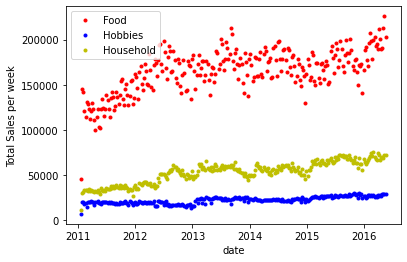

In [ ]:
plt.plot(sales_cat["date"], sales_cat["FOODS"], '.r', label = "Food")
plt.plot(sales_cat["date"], sales_cat["HOBBIES"], '.b', label = "Hobbies")
plt.plot(sales_cat["date"], sales_cat["HOUSEHOLD"], '.y', label = "Household")
plt.legend(loc = "upper left")
plt.xlabel("date")
plt.ylabel("Total Sales per week")
plt.show()
#Food and Hobby categories have increasing trend, Household have a smooth trend
#Food sales is the highest. 
#We will try to do difference first for Food and Hobby sales.
#And we will try to do ARMA model for household category

Text(0.5, 1.0, 'aggregate weekly sales per category')

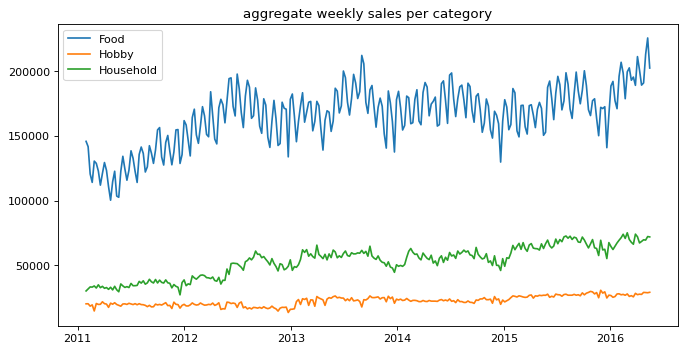

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 5), dpi=80)
sales_cat1 = sales_cat.copy()
sales_cat1 = sales_cat1.iloc[1:,:]
plt.plot(sales_cat1["date"], sales_cat1["FOODS"], label="Food")
plt.plot(sales_cat1["date"], sales_cat1["HOBBIES"], label="Hobby")
plt.plot(sales_cat1["date"], sales_cat1["HOUSEHOLD"], label="Household")
plt.legend(loc = "upper left")
plt.title("aggregate weekly sales per category")

Text(0.5, 1.0, 'Household')

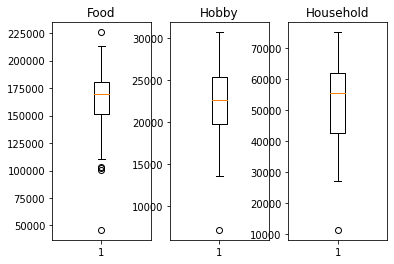

In [ ]:
fig, axes = plt.subplots(1, 3, sharex=False)
axes[0].boxplot(sales_cat["FOODS"])
axes[0].set_title('Food')

axes[1].boxplot(sales_cat["HOBBIES"])
axes[1].set_title('Hobby')

axes[2].boxplot(sales_cat["HOUSEHOLD"])
axes[2].set_title('Household')
#There are some outliers

## Food Category - SARIMA

In [ ]:
sales_food_value = sales_cat[sales_cat["FOODS"] > 75000]["FOODS"] #remove one outlier, which is at first week that may not be a whole week

In [ ]:
result = adfuller(sales_food_value)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#ADF test 
#NULL Hypothesis: time series is non-stationary
#P-value is greater than the significance level, we will difference the series and see how the autocorrelation plot looks like.

ADF Statistic: -2.318115
p-value: 0.166192


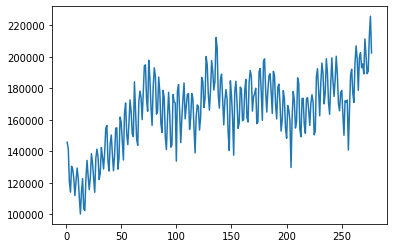

In [ ]:
plt.plot(sales_food_value.dropna()) #orginal

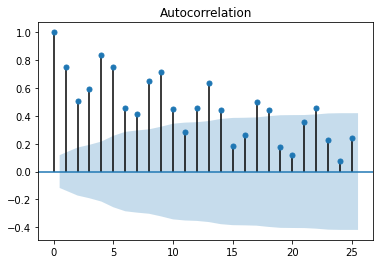

In [ ]:
plot_acf(sales_food_value); #original

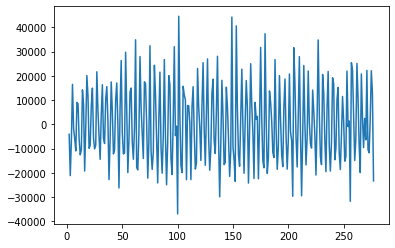

In [ ]:
plt.plot(sales_food_value.diff().dropna()) 

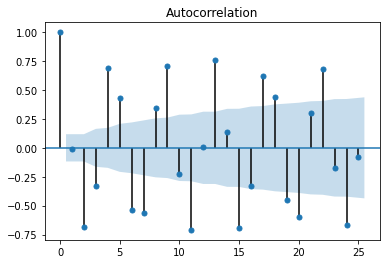

In [ ]:
plot_acf(sales_food_value.diff().dropna()); 

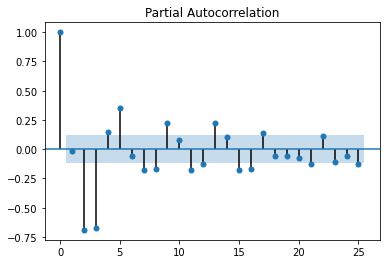

In [ ]:
plot_pacf(sales_food_value.diff().dropna()); #pacf = 4

In [ ]:
#stationary check
result = adfuller(sales_food_value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#The P-value is < 0.005, 1st order accepted

ADF Statistic: -4.168297
p-value: 0.000745


In [ ]:
model = ARIMA(sales_food_value, order=(4,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

                             ARIMA Model Results                              
Dep. Variable:                D.FOODS   No. Observations:                  276
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2883.041
Method:                       css-mle   S.D. of innovations           8272.360
Date:                Mon, 12 Dec 2022   AIC                           5780.082
Time:                        14:16:50   BIC                           5805.425
Sample:                             1   HQIC                          5790.252
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           270.5563    268.362      1.008      0.313    -255.423     796.536
ar.L1.D.FOODS     0.1106      0.113      0.978      0.328      -0.111       0.332
ar.L2.D.FOODS    -0.3374      0.066     

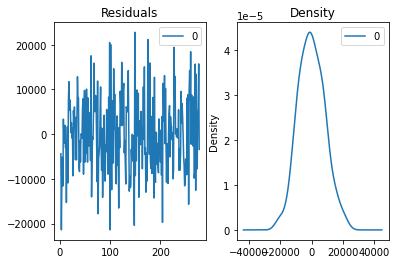

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

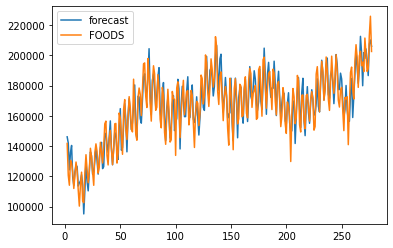

In [ ]:
model_fit.plot_predict(dynamic=False) #ARIMA(4, 1, 1)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

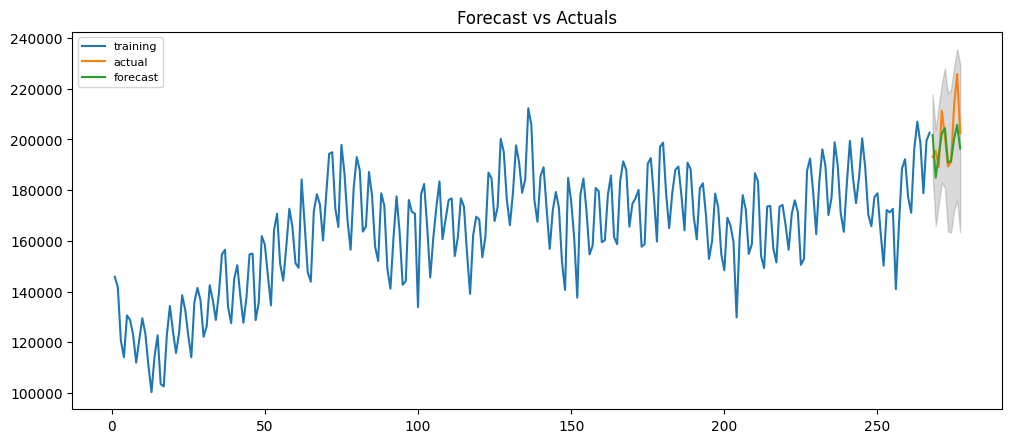

In [ ]:
# Create Training and Test
train = sales_food_value[:267]
test = sales_food_value[267:]

# Build Model
model = ARIMA(train, order=(4, 1, 1))  
fitted = model.fit()  
#print(fitted.summary())

# Forecast next ten weeks'food sales
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf
y_pred_food_arima = fc
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
y = np.array(test)
y_pred = np.array(fc)
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (max(y) - min(y)))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (np.mean(y)))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(y, y_pred)) / 100000))
print("rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred))))

range normalized rmse = 49.850340640400184
mean normalized rmse = 21.274984120655002
rmse divided by 100000 = 0.09543183390151017
rmse = 9543.183390151016


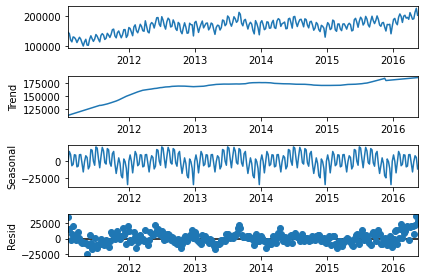

In [ ]:
#Let's try SARIMA, since food category seems like seasonality
ts_food = sales_cat[sales_cat["FOODS"] > 75000][["date", "FOODS"]].set_index("date")
result_seasonal = seasonal_decompose(ts_food, model='additive',extrapolate_trend='freq')
result_seasonal.plot()
plt.show()

In [ ]:
result = adfuller(result_seasonal.seasonal.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#The P-value is < 0.005, seasonal series accepted

ADF Statistic: -4.475613
p-value: 0.000218


In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, ts_food['FOODS'])
import warnings
warnings.filterwarnings('ignore')
result_df

<ipython-input-555-1c6b5188e689>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was

,"(p,q)x(P,Q)",AIC
0,"(3, 2, 3, 1)",5736.836922
1,"(3, 2, 0, 2)",5737.181175
2,"(3, 3, 2, 3)",5739.060150
3,"(3, 2, 0, 3)",5740.439168
4,"(3, 2, 1, 2)",5741.935872
...,...,...
251,"(0, 0, 0, 1)",5904.932839
252,"(0, 0, 0, 2)",5905.457730
253,"(0, 0, 3, 0)",5905.554366
254,"(0, 0, 2, 0)",5905.653092


In [ ]:
best_model = SARIMAX(ts_food['FOODS'], order=(3, 1, 2), seasonal_order=(3, 1, 1, 4)).fit(dis=-1) #The first row in resulted_df
print(best_model.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                      
Dep. Variable:                               FOODS   No. Observations:                  277
Model:             SARIMAX(3, 1, 2)x(3, 1, [1], 4)   Log Likelihood               -2858.418
Date:                             Mon, 12 Dec 2022   AIC                           5736.837
Time:                                     14:17:10   BIC                           5772.895
Sample:                                 01-30-2011   HQIC                          5751.313
                                      - 05-15-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0874      0.083      1.049      0.294      -0.076       0.251
ar.L2         -0.9569      

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


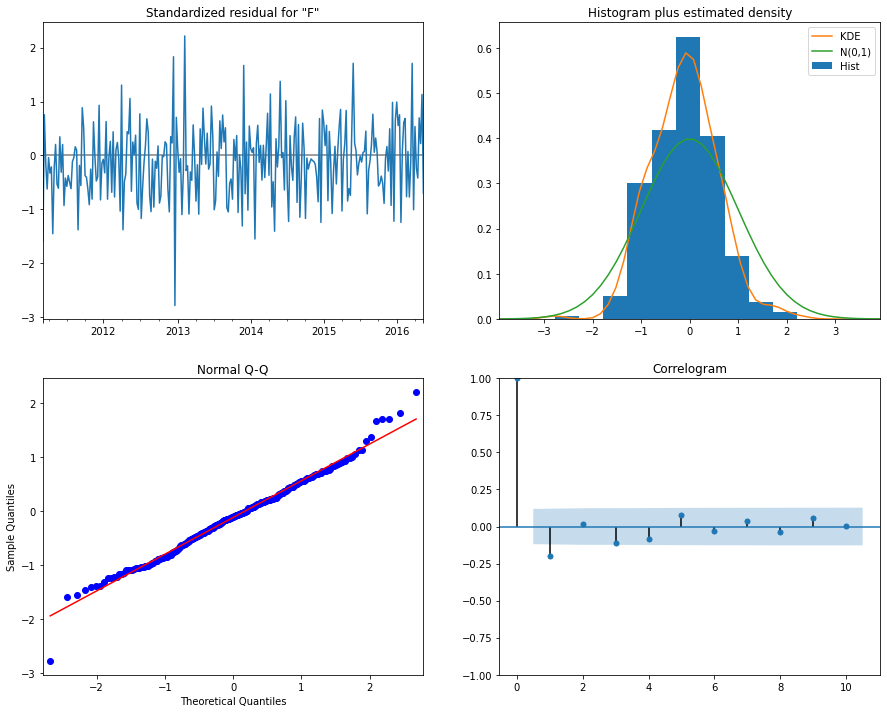

In [ ]:
best_model.plot_diagnostics(figsize=(15,12));

<ipython-input-30-59a66f5ac7b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_food['arima_model'][:4+1] = np.NaN


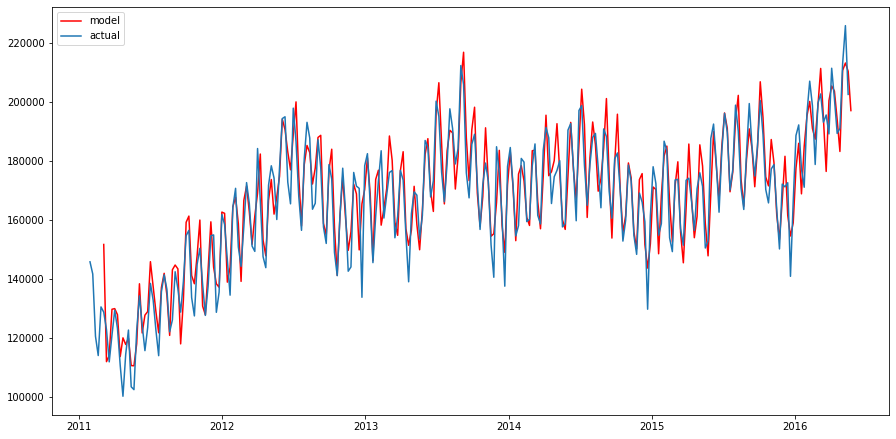

In [ ]:
ts_food['arima_model'] = best_model.fittedvalues
ts_food['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=ts_food.shape[0], end=ts_food.shape[0])
forecast = ts_food['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
#plt.axvspan(ts_food.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_food['FOODS'], label='actual')
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


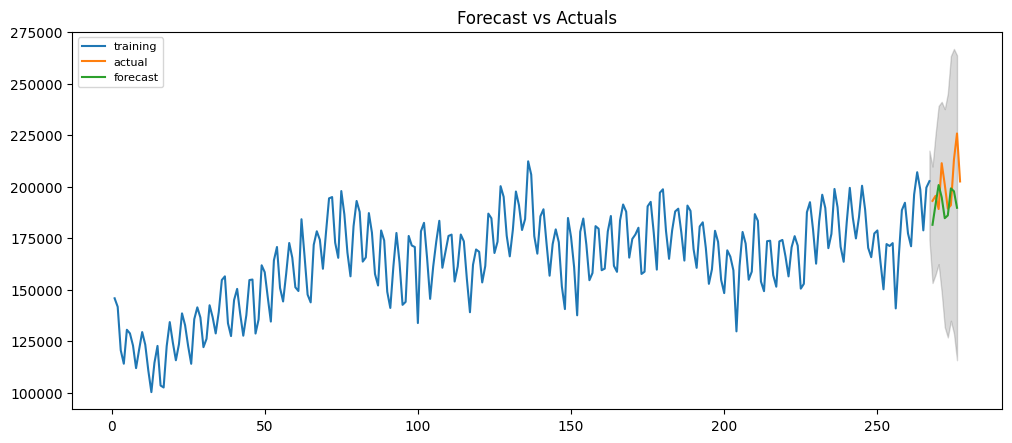

In [ ]:
# Create Training and Test
train = sales_food_value[:267]
test = sales_food_value[267:]

# Build Model
model = SARIMAX(train, order=(3, 1, 2), seasonal_order=(3, 1, 1, 4)) 
fitted = model.fit(dis=-1) 
# Forecast next ten weeks'food sales
conf = fitted.get_forecast(10, alpha=0.05).conf_int(alpha=0.05)  # 95% conf
fc = fitted.forecast(10, alpha=0.05)
y_pred_food_sarima = fc
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = conf.iloc[:, 0]
upper_series = conf.iloc[:, 1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
y = np.array(test)
y_pred = np.array(fc)
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (max(y) - min(y)))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (np.mean(y)))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(y, y_pred)) / 100000))
print("rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred))))

range normalized rmse = 65.02249496255405
mean normalized rmse = 27.75011223679779
rmse divided by 100000 = 0.12447690144968337
rmse = 12447.690144968337


## Hobby Category - ARIMA

In [ ]:
sales_hobby_value = sales_cat[sales_cat["HOBBIES"] > 10000]["HOBBIES"] #remove one outlier, which is at first week that may not be a whole week

In [ ]:
result = adfuller(sales_hobby_value)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#ADF test 
#NULL Hypothesis: time series is non-stationary
#P-value is greater than the significance level, we will difference the series and see how the autocorrelation plot looks like.

ADF Statistic: -1.512934
p-value: 0.527104


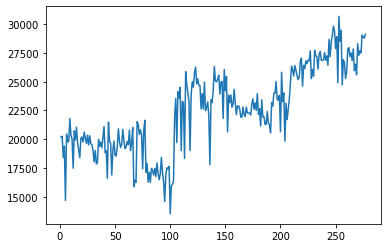

In [ ]:
plt.plot(sales_hobby_value.dropna()) #orginal

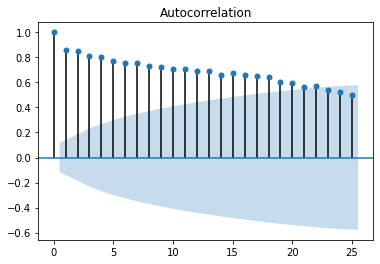

In [ ]:
plot_acf(sales_hobby_value.dropna()); #orginal

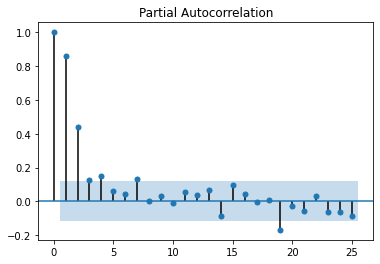

In [ ]:
plot_pacf(sales_hobby_value.dropna()); #orginal

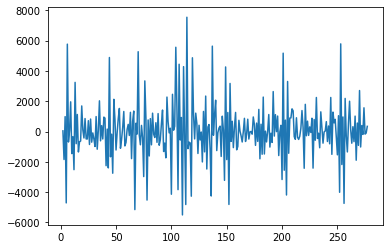

In [ ]:
plt.plot(sales_hobby_value.diff().dropna()) #diff

In [ ]:
result = adfuller(sales_hobby_value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#ADF test 
#NULL Hypothesis: time series is non-stationary
#P-value is greater than the significance level, we will difference the series and see how the autocorrelation plot looks like.

ADF Statistic: -9.857609
p-value: 0.000000


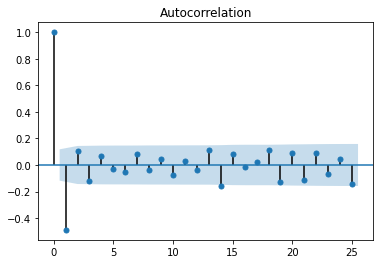

In [ ]:
plot_acf(sales_hobby_value.diff().dropna()); #orginal

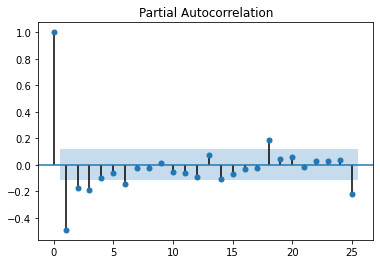

In [ ]:
plot_pacf(sales_hobby_value.diff().dropna()); #orginal

In [ ]:
model = ARIMA(sales_hobby_value, order=(4,1,2))#ARIMA (4, 1, 2)
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

                             ARIMA Model Results                              
Dep. Variable:              D.HOBBIES   No. Observations:                  276
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -2422.952
Method:                       css-mle   S.D. of innovations           1569.844
Date:                Mon, 12 Dec 2022   AIC                           4861.905
Time:                        14:17:55   BIC                           4890.868
Sample:                             1   HQIC                          4873.527
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              33.0286     28.095      1.176      0.240     -22.036      88.093
ar.L1.D.HOBBIES    -0.7326      0.200     -3.657      0.000      -1.125      -0.340
ar.L2.D.HOBBIES     0.2352      

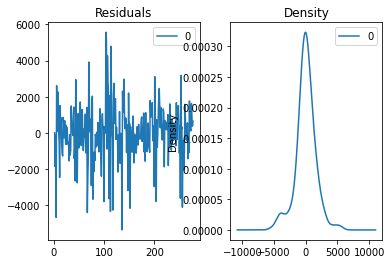

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

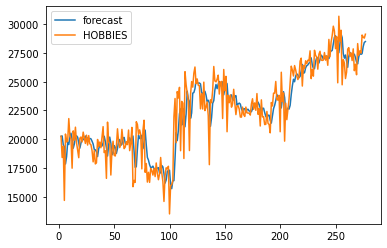

In [ ]:
model_fit.plot_predict(dynamic=False) #ARIMA(4, 1, 2)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

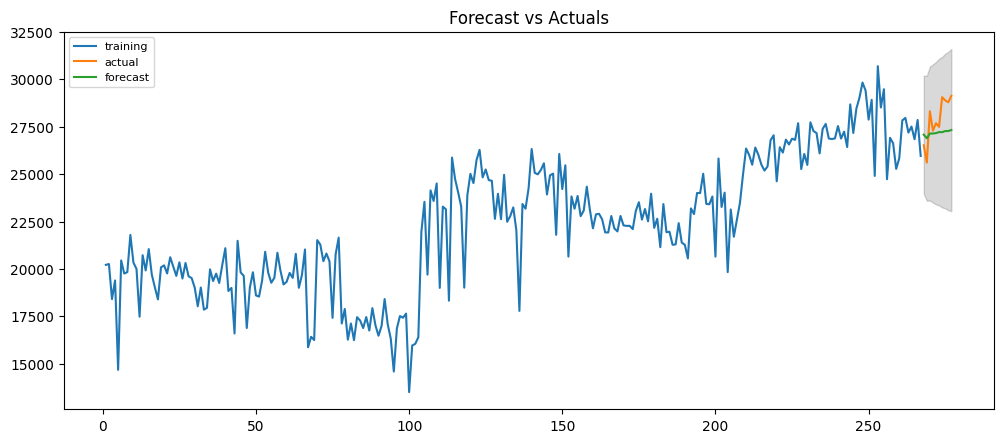

In [ ]:
# Create Training and Test
train = sales_hobby_value[:267]
test = sales_hobby_value[267:]

# Build Model
model = ARIMA(train, order=(4, 1, 2))  
fitted = model.fit()  
#print(fitted.summary())

# Forecast next ten weeks'food sales
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf
y_pred_hobby_arima = fc
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
y = np.array(test)
y_pred = np.array(fc)
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (max(y) - min(y)))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (np.mean(y)))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(y, y_pred)) / 100000))
print("rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred))))

range normalized rmse = 20.832262969042116
mean normalized rmse = 7.405974573245833
rmse divided by 100000 = 0.012364961563179615
rmse = 1236.4961563179615


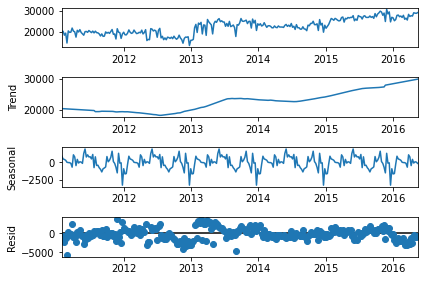

In [ ]:
#Let's try SARIMA, since food category seems like seasonality
ts_hobby = sales_cat[sales_cat["HOBBIES"] > 10000][["date", "HOBBIES"]].set_index("date")
result_seasonal = seasonal_decompose(ts_hobby, model='additive',extrapolate_trend='freq')
result_seasonal.plot()
plt.show()

In [ ]:
result = adfuller(result_seasonal.seasonal.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#The P-value is > 0.005, seasonal series not accepted

ADF Statistic: -2.741342
p-value: 0.067153


## Household Category - SARIMA

In [ ]:
sales_house_value = sales_cat[sales_cat["HOUSEHOLD"] > 20000]["HOUSEHOLD"] #remove one outlier, which is at first week that may not be a whole week

In [ ]:
result = adfuller(sales_house_value)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#ADF test 
#NULL Hypothesis: time series is non-stationary
#P-value is greater than the significance level, we will difference the series and see how the autocorrelation plot looks like.

ADF Statistic: -1.223104
p-value: 0.663579


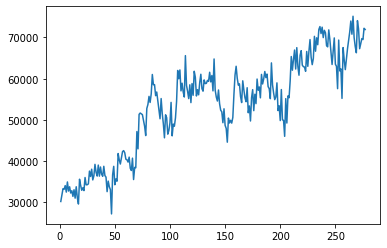

In [ ]:
plt.plot(sales_house_value.dropna()) #orginal

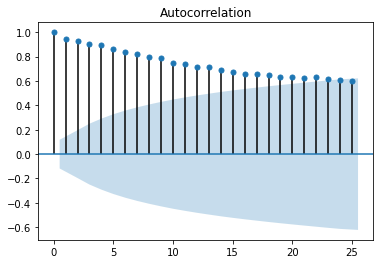

In [ ]:
plot_acf(sales_house_value.dropna()); #orginal

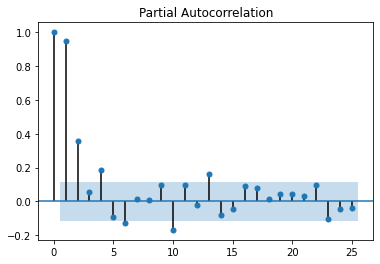

In [ ]:
plot_pacf(sales_house_value.dropna()); #orginal

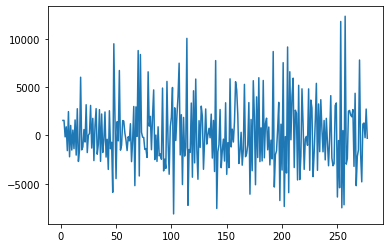

In [ ]:
plt.plot(sales_house_value.diff().dropna()) #orginal

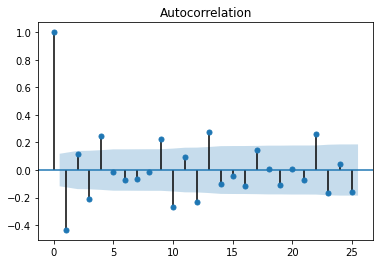

In [ ]:
plot_acf(sales_house_value.diff().dropna()); #orginal

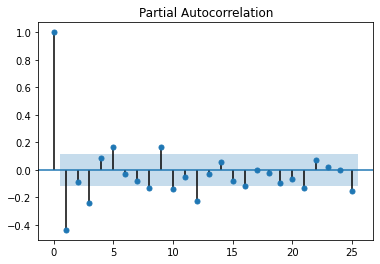

In [ ]:
plot_pacf(sales_house_value.diff().dropna()); #orginal

In [ ]:
result = adfuller(sales_house_value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#ADF test 
#NULL Hypothesis: time series is stationary
#P-value is greater than the significance level, we will difference the series and see how the autocorrelation plot looks like.

ADF Statistic: -6.730313
p-value: 0.000000


In [ ]:
model = ARIMA(sales_house_value, order=(6,1,2))#ARIMA (4, 1, 2)
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

                             ARIMA Model Results                              
Dep. Variable:            D.HOUSEHOLD   No. Observations:                  276
Model:                 ARIMA(6, 1, 2)   Log Likelihood               -2592.271
Method:                       css-mle   S.D. of innovations           2862.467
Date:                Mon, 12 Dec 2022   AIC                           5204.542
Time:                        14:18:48   BIC                           5240.746
Sample:                             1   HQIC                          5219.070
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               151.3658    115.034      1.316      0.188     -74.096     376.828
ar.L1.D.HOUSEHOLD    -0.2235      0.062     -3.611      0.000      -0.345      -0.102
ar.L2.D.HOUSEHOLD    -0.

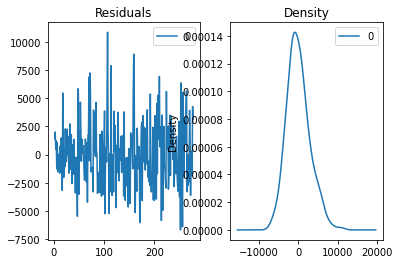

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

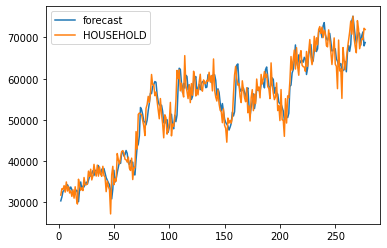

In [ ]:
model_fit.plot_predict(dynamic=False) #ARIMA(6, 1, 2)
plt.show()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

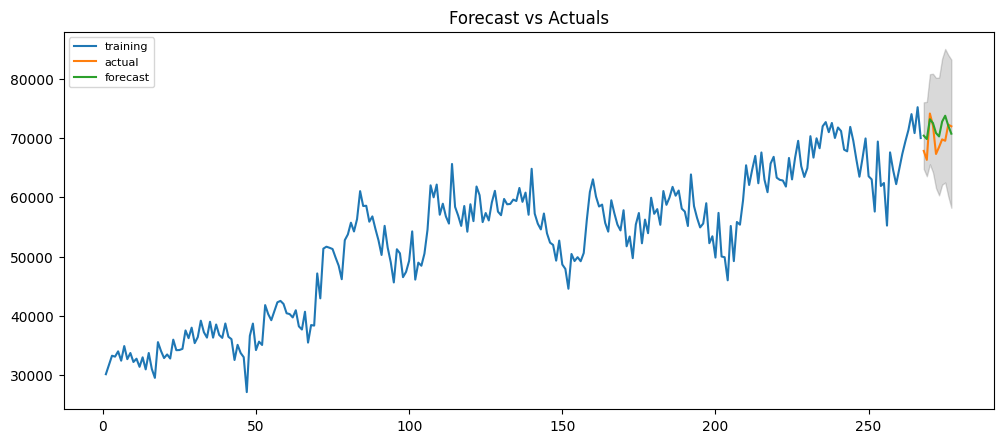

In [ ]:
# Create Training and Test
train = sales_house_value[:267]
test = sales_house_value[267:]

# Build Model
model = ARIMA(train, order=(6, 1, 2))  
fitted = model.fit()  
#print(fitted.summary())

# Forecast next ten weeks'food sales
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf
y_pred_house_arima = fc
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
y = np.array(test)
y_pred = np.array(fc)
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (max(y) - min(y)))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (np.mean(y)))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(y, y_pred)) / 100000))
print("rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred))))

range normalized rmse = 28.62635422081461
mean normalized rmse = 9.564561345862504
rmse divided by 100000 = 0.025295073357982374
rmse = 2529.5073357982374


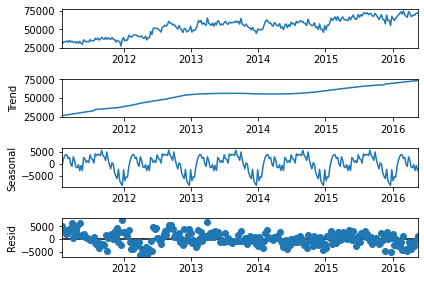

In [ ]:
#Let's try SARIMA, since food category seems like seasonality
ts_house = sales_cat[sales_cat["HOUSEHOLD"] > 20000][["date", "HOUSEHOLD"]].set_index("date")
result_seasonal = seasonal_decompose(ts_house, model='additive',extrapolate_trend='freq')
result_seasonal.plot()
plt.show()

In [ ]:
result = adfuller(result_seasonal.seasonal.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#The P-value is < 0.005, seasonal series accepted

ADF Statistic: -4.998117
p-value: 0.000022


In [ ]:
p = range(0, 6, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

384


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, ts_house['HOUSEHOLD'])
import warnings
warnings.filterwarnings('ignore')
result_df

<ipython-input-26-1c6b5188e689>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/384 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was

,"(p,q)x(P,Q)",AIC
0,"(4, 2, 0, 2)",5190.344194
1,"(4, 3, 0, 1)",5192.451865
2,"(4, 2, 0, 1)",5192.559207
3,"(5, 3, 0, 1)",5192.951578
4,"(0, 1, 3, 1)",5193.761992
...,...,...
283,"(0, 2, 0, 0)",5302.777857
284,"(1, 2, 0, 0)",5302.967905
285,"(0, 0, 2, 0)",5311.675444
286,"(0, 0, 1, 0)",5317.727457


In [ ]:
#(4202)
best_model = SARIMAX(ts_house['HOUSEHOLD'], order=(4, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1) #The first row in resulted_df
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         HOUSEHOLD   No. Observations:                  277
Model:             SARIMAX(4, 1, 2)x(0, 1, 2, 4)   Log Likelihood               -2586.172
Date:                           Mon, 12 Dec 2022   AIC                           5190.344
Time:                                   14:28:55   BIC                           5222.796
Sample:                               01-30-2011   HQIC                          5203.373
                                    - 05-15-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1281      0.072     -1.786      0.074      -0.269       0.012
ar.L2         -0.8277      0.091     -9.129

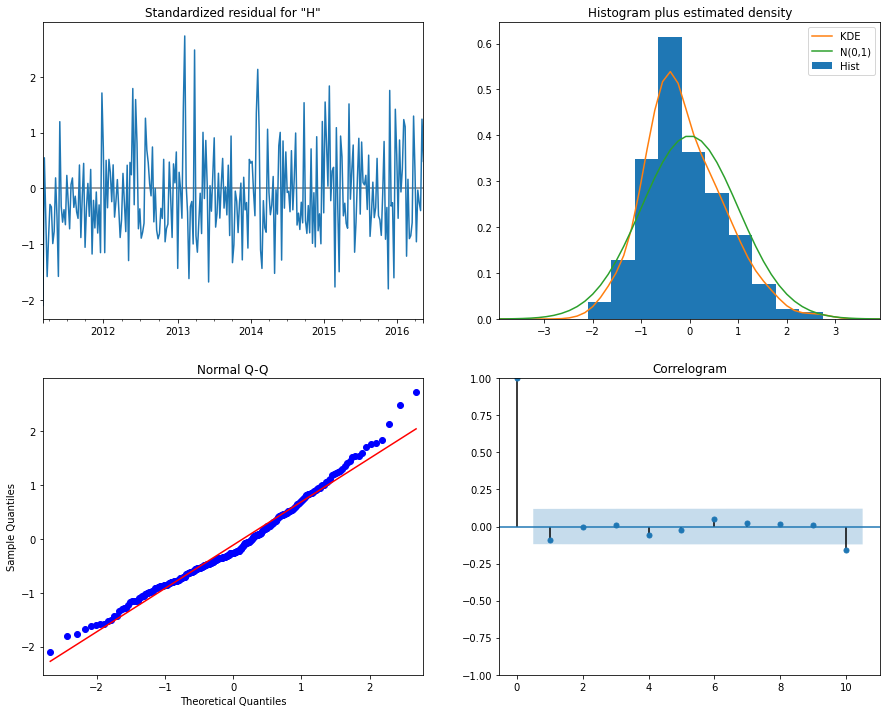

In [ ]:
best_model.plot_diagnostics(figsize=(15,12));


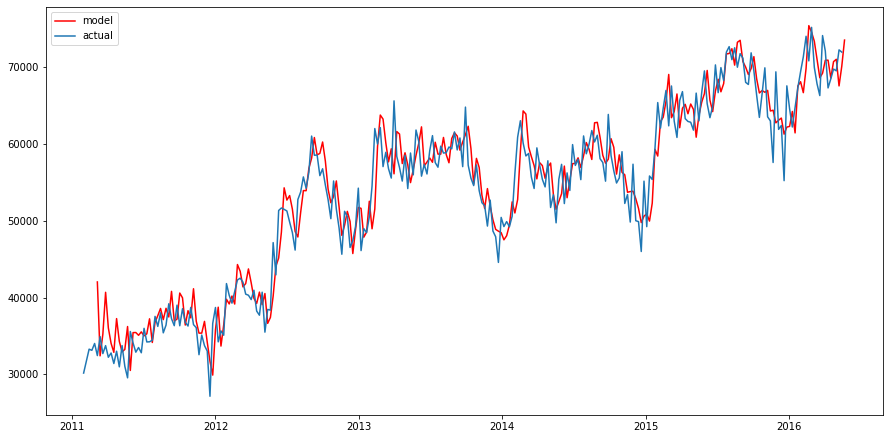

In [ ]:
ts_house['arima_model'] = best_model.fittedvalues
ts_house['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=ts_house.shape[0], end=ts_house.shape[0])
forecast = ts_house['arima_model'].append(forecast)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
#plt.axvspan(ts_house.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_house['HOUSEHOLD'], label='actual')
plt.legend()
plt.show()

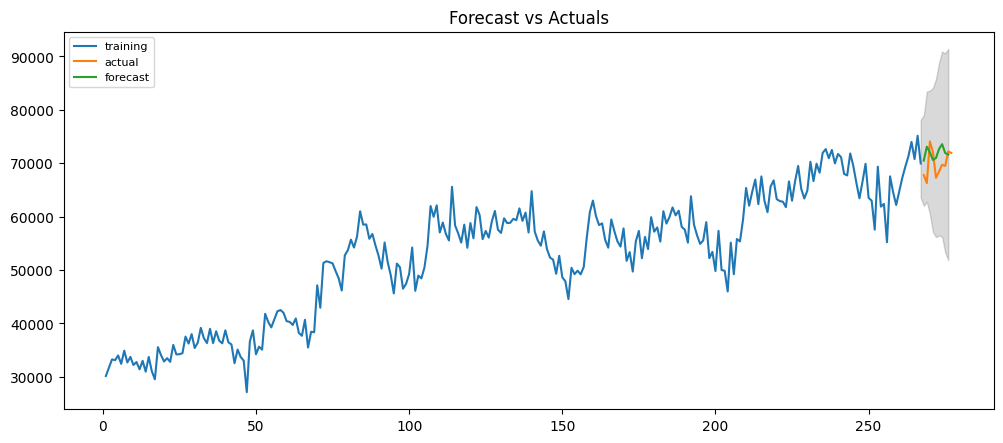

In [ ]:
# Create Training and Test
train = sales_house_value[:267]
test = sales_house_value[267:]

# Build Model
model = SARIMAX(train, order=(4, 1, 2), seasonal_order=(0, 1, 2, 4)) 
fitted = model.fit(dis=-1) 
# Forecast next ten weeks'food sales
conf = fitted.get_forecast(10, alpha=0.05).conf_int(alpha=0.05)  # 95% conf
fc = fitted.forecast(10, alpha=0.05)
y_pred_house_sarima = fc
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = conf.iloc[:, 0]
upper_series = conf.iloc[:, 1]

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
y = np.array(test)
y_pred = np.array(fc)
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (max(y) - min(y)))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred) / (np.mean(y)))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(y, y_pred)) / 100000))
print("rmse = {0}".format(np.sqrt(mean_squared_error(y, y_pred))))

range normalized rmse = 30.209782411983525
mean normalized rmse = 10.093612162266894
rmse divided by 100000 = 0.026694236239282573
rmse = 2669.4236239282573


In [ ]:
y_pred_all_arima = y_pred_food_sarima + y_pred_hobby_arima + y_pred_house_sarima
y_true_all = sales_cat.iloc[268: , 1] + sales_cat.iloc[268:, 2] + sales_cat.iloc[268:, 3]
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(y_true_all, y_pred_all_arima) / (max(y_true_all) - min(y_true_all)))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(y_true_all, y_pred_all_arima) / (np.mean(y_true_all)))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(y_true_all, y_pred_all_arima)) / 100000))
print("rmse = {0}".format(np.sqrt(mean_squared_error(y_true_all, y_pred_all_arima))))
print("MAE divided by 100000:", np.mean(np.abs(y_pred_all_arima - y_true_all) / 100000))

range normalized rmse = 60.2089980586356
mean normalized rmse = 22.44435722860406
rmse divided by 100000 = 0.12273335105118392
rmse = 12273.335105118393
MAE: 0.12868653270423586


## Food Category - GP

In [ ]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y:/ given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        plt.plot(all_x.reshape(-1, 1), samples)
    
    plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.85, 0.85, 0.85), fmt = "r-", 
                 label="pred mean")
    plt.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        plt.plot(x_pred, true_y, "b-", label="truth function")
    plt.legend()

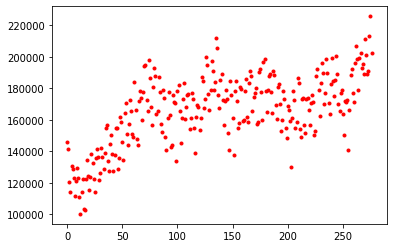

In [ ]:
sales_cat_food = sales_cat[sales_cat["FOODS"] > 75000]
sales_cat_food["date"] = range(0, 277)
plt.plot(sales_cat_food["date"], sales_cat_food["FOODS"], '.r')
plt.show()

In [ ]:
df_test = sales_cat_food[(sales_cat_food["date"].between(267, 277))]
df_train = sales_cat_food[ (sales_cat_food["date"] < 267)  ]
X_train = df_train["date"].to_numpy()
y_train = df_train["FOODS"].to_numpy()

X_test = df_test["date"].to_numpy()
y_test =  df_test["FOODS"].to_numpy()

all_x = sales_cat_food["date"].to_numpy()
true_y = sales_cat_food["FOODS"].to_numpy()

In [ ]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel

In [ ]:
kernel = 10 * RBF(length_scale = 2) * ExpSineSquared(length_scale=1.0, periodicity=1.0, 
                                                     length_scale_bounds = (1e-05, 1e5),
                                                     periodicity_bounds= (1e-05, 1e5))

In [ ]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel)

3.16**2 * RBF(length_scale=2) * ExpSineSquared(length_scale=1, periodicity=1)


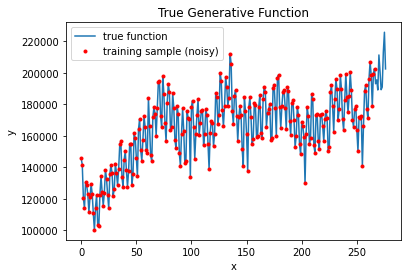

In [ ]:
plt.figure()
plt.plot(all_x, true_y, label='true function')
plt.plot(X_train, y_train, '.r', label='training sample (noisy)')
plt.title("True Generative Function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [ ]:
kernel = 33**2 * RBF(length_scale = 40.6) * ExpSineSquared(length_scale=0.6, periodicity=70, 
                                                     length_scale_bounds = (0, 300),
                                                     periodicity_bounds= (0, 300)) + WhiteKernel(noise_level = 1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

33**2 * RBF(length_scale=40.6) * ExpSineSquared(length_scale=0.364, periodicity=30.5) + WhiteKernel(noise_level=1)


rmse = 18975.61728195758
rmse divided by 100000 = 0.1897561728195758
range normalized rmse = 99.12216361090813
mean normalized rmse = 42.303070144278735


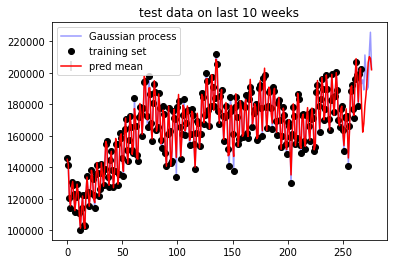

In [ ]:
y_test = true_y
X_test = all_x
mus, sigmas = gp.predict(X_test.reshape(-1,1), return_std=True)

plt.plot(all_x, true_y, color="blue", alpha=0.4, label="Gaussian process")
plot_gp(X_test, mus[:, 0], sigmas, X_train, y_train)
plt.title("test data on last 10 weeks")
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:])) / 100000 ))
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / (max(y_test[-10:]) - min(y_test[-10:])))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / np.mean(y_test[-10:]))))
y_pred_food_gp = mus[-10:]

In [ ]:
kernel = 31**2 * RBF(length_scale = 40.6) * ExpSineSquared(length_scale=0.9, periodicity=50, 
                                                     length_scale_bounds = (0, 300),
                                                     periodicity_bounds= (0, 300)) + WhiteKernel(noise_level = 1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

316**2 * RBF(length_scale=243) * ExpSineSquared(length_scale=6.42, periodicity=48.1) + WhiteKernel(noise_level=1e+05)


rmse = 31680.066896385764
rmse divided by 100000 = 0.31680066896385767
range normalized rmse = 165.48588261704825
mean normalized rmse = 70.62558609713878


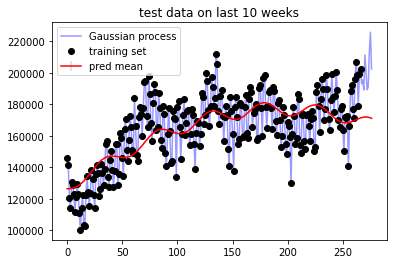

In [ ]:
y_test = true_y
X_test = all_x
mus, sigmas = gp.predict(X_test.reshape(-1,1), return_std=True)

plt.plot(all_x, true_y, color="blue", alpha=0.4, label="Gaussian process")
plot_gp(X_test, mus[:, 0], sigmas, X_train, y_train)
plt.title("test data on last 10 weeks")
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:])) / 100000 ))
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / (max(y_test[-10:]) - min(y_test[-10:])))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / np.mean(y_test[-10:]))))


## Hobby Category - GP

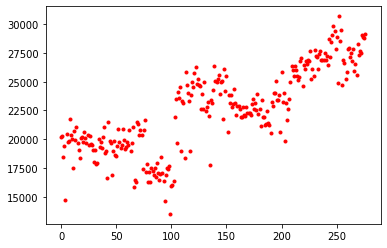

In [ ]:
sales_cat_hobby = sales_cat[sales_cat["HOBBIES"] > 10000]
sales_cat_hobby["date"] = range(0, 277)
plt.plot(sales_cat_hobby["date"], sales_cat_hobby["HOBBIES"], '.r')
plt.show()

In [ ]:
df_test = sales_cat_hobby[(sales_cat_food["date"].between(267, 277))]
df_train = sales_cat_hobby[ (sales_cat_food["date"] < 267)  ]
X_train = df_train["date"].to_numpy()
y_train = df_train["HOBBIES"].to_numpy()

X_test = df_test["date"].to_numpy()
y_test =  df_test["HOBBIES"].to_numpy()

all_x = sales_cat_hobby["date"].to_numpy()
true_y = sales_cat_hobby["HOBBIES"].to_numpy()

In [ ]:
kernel = 10 * RBF(length_scale = 2) * ExpSineSquared(length_scale=1.0, periodicity=1.0, 
                                                     length_scale_bounds = (1e-05, 1e5),
                                                     periodicity_bounds= (1e-05, 1e5))

In [ ]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel)

3.16**2 * RBF(length_scale=2) * ExpSineSquared(length_scale=1, periodicity=1)


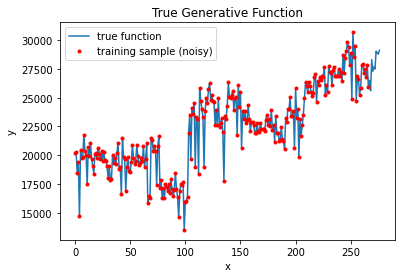

In [ ]:
plt.figure()
plt.plot(all_x, true_y, label='true function')
plt.plot(X_train, y_train, '.r', label='training sample (noisy)')
plt.title("True Generative Function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [ ]:
kernel = 10**2 * RBF(length_scale = 3) * ExpSineSquared(length_scale=0.52, periodicity=20.4, 
                                                     length_scale_bounds = (0, 350),
                                                     periodicity_bounds= (0, 350)) + WhiteKernel(noise_level = 1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

316**2 * RBF(length_scale=278) * ExpSineSquared(length_scale=1.72, periodicity=225) + WhiteKernel(noise_level=1e+05)


rmse = 2950.0839381384135
rmse divided by 100000 = 0.029500839381384134
range normalized rmse = 49.70247911085567
mean normalized rmse = 17.669482046635498


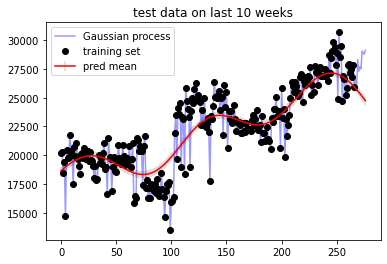

In [ ]:
y_test = true_y
X_test = all_x
# X_test = df_test["date"].to_numpy()
# y_test =  df_test["HOBBIES"].to_numpy()
mus, sigmas = gp.predict(X_test.reshape(-1,1), return_std=True)

plt.plot(all_x, true_y, color="blue", alpha=0.4, label="Gaussian process")
plot_gp(X_test, mus[:, 0], sigmas, X_train, y_train)
plt.title("test data on last 10 weeks")
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:])) / 100000 ))
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / (max(y_test[-10:]) - min(y_test[-10:])))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / np.mean(y_test[-10:]))))
y_pred_hobby_gp = mus[-10:]

In [ ]:
kernel = 20**2 * RBF(length_scale = 30) * ExpSineSquared(length_scale=0.88, periodicity=14, 
                                                     length_scale_bounds = (0, 350),
                                                     periodicity_bounds= (0, 350)) + WhiteKernel(noise_level = 1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

20**2 * RBF(length_scale=30) * ExpSineSquared(length_scale=0.338, periodicity=10.5) + WhiteKernel(noise_level=1)


rmse = 4254.539103149738
rmse divided by 100000 = 0.04254539103149738
range normalized rmse = 71.6797031321273
mean normalized rmse = 25.482496049672022


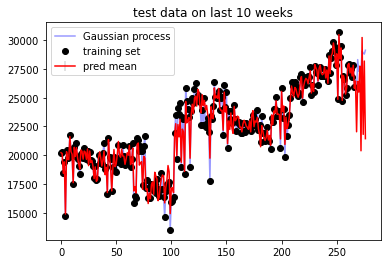

In [ ]:
y_test = true_y
X_test = all_x
mus, sigmas = gp.predict(X_test.reshape(-1,1), return_std=True)

plt.plot(all_x, true_y, color="blue", alpha=0.4, label="Gaussian process")
plot_gp(X_test, mus[:, 0], sigmas, X_train, y_train)
plt.title("test data on last 10 weeks")
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:])) / 100000 ))
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / (max(y_test[-10:]) - min(y_test[-10:])))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / np.mean(y_test[-10:]))))

## Household Category - GP

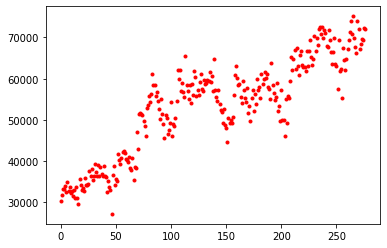

In [ ]:
sales_cat_house = sales_cat[sales_cat["HOUSEHOLD"] > 20000]
sales_cat_house["date"] = range(0, 277)
plt.plot(sales_cat_house["date"], sales_cat_house["HOUSEHOLD"], '.r')
plt.show()

In [ ]:
df_test = sales_cat_house[(sales_cat_house["date"].between(267, 277))]
df_train = sales_cat_house[ (sales_cat_house["date"] < 267)  ]
X_train = df_train["date"].to_numpy()
y_train = df_train["HOUSEHOLD"].to_numpy()

X_test = df_test["date"].to_numpy()
y_test =  df_test["HOUSEHOLD"].to_numpy()

all_x = sales_cat_house["date"].to_numpy()
true_y = sales_cat_house["HOUSEHOLD"].to_numpy()

In [ ]:
kernel = 10 * RBF(length_scale = 2) * ExpSineSquared(length_scale=1.0, periodicity=1.0, 
                                                     length_scale_bounds = (1e-05, 1e5),
                                                     periodicity_bounds= (1e-05, 1e5))

In [ ]:
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel)

3.16**2 * RBF(length_scale=2) * ExpSineSquared(length_scale=1, periodicity=1)


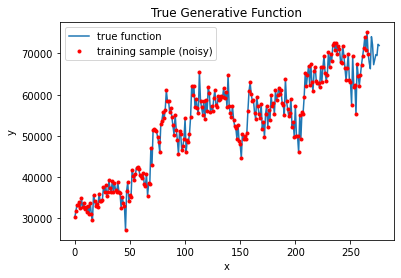

In [ ]:
plt.figure()
plt.plot(all_x, true_y, label='true function')
plt.plot(X_train, y_train, '.r', label='training sample (noisy)')
plt.title("True Generative Function")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [ ]:
kernel = 3**2 * RBF(length_scale = 13) * ExpSineSquared(length_scale=0.9, periodicity=14, 
                                                     length_scale_bounds = (0, 350),
                                                     periodicity_bounds= (0, 350)) + WhiteKernel(noise_level = 1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

316**2 * RBF(length_scale=225) * ExpSineSquared(length_scale=2.49, periodicity=51.7) + WhiteKernel(noise_level=1e+05)


rmse = 5882.514107738763
rmse divided by 100000 = 0.058825141077387635
range normalized rmse = 66.57222541872115
mean normalized rmse = 22.242934920611287


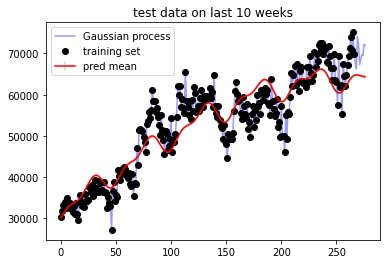

In [ ]:
y_test = true_y
X_test = all_x
mus, sigmas = gp.predict(X_test.reshape(-1,1), return_std=True)

plt.plot(all_x, true_y, color="blue", alpha=0.4, label="Gaussian process")
plot_gp(X_test, mus[:, 0], sigmas, X_train, y_train)
plt.title("test data on last 10 weeks")
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:])) / 100000 ))
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / (max(y_test[-10:]) - min(y_test[-10:])))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / np.mean(y_test[-10:]))))
y_pred_house_gp = mus[-10:]

In [ ]:
kernel = 32**2 * RBF(length_scale = 30) * ExpSineSquared(length_scale=0.7, periodicity=9, 
                                                     length_scale_bounds = (0, 350),
                                                     periodicity_bounds= (0, 350)) + WhiteKernel(noise_level = 1)

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

32**2 * RBF(length_scale=30) * ExpSineSquared(length_scale=0.7, periodicity=5.26) + WhiteKernel(noise_level=1)


rmse = 8740.223943049376
rmse divided by 100000 = 0.08740223943049376
range normalized rmse = 98.91283690783227
mean normalized rmse = 33.048494027589555


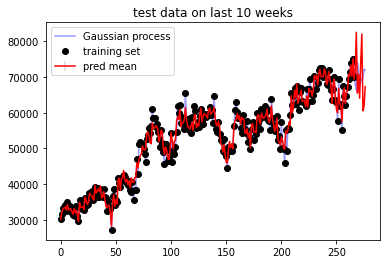

In [ ]:
y_test = true_y
X_test = all_x
mus, sigmas = gp.predict(X_test.reshape(-1,1), return_std=True)

plt.plot(all_x, true_y, color="blue", alpha=0.4, label="Gaussian process")
plot_gp(X_test, mus[:, 0], sigmas, X_train, y_train)
plt.title("test data on last 10 weeks")
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:])) / 100000 ))
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / (max(y_test[-10:]) - min(y_test[-10:])))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(mus[-10:], y_test[-10:]) / np.mean(y_test[-10:]))))

In [ ]:
y_pred_all_gp = (y_pred_food_gp + y_pred_hobby_gp + y_pred_house_gp)[:,0]
print("range normalized rmse = {0}".format(np.sqrt(mean_squared_error(y_true_all, y_pred_all_gp) / (max(y_true_all) - min(y_true_all)))))
print("mean normalized rmse = {0}".format(np.sqrt(mean_squared_error(y_true_all, y_pred_all_gp) / (np.mean(y_true_all)))))
print("rmse divided by 100000 = {0}".format(np.sqrt(mean_squared_error(y_true_all, y_pred_all_gp)) / 100000))
print("rmse = {0}".format(np.sqrt(mean_squared_error(y_true_all, y_pred_all_gp))))
print("MAE divided by 100000:", np.mean(np.abs(y_pred_all_gp - y_true_all) / 100000))

range normalized rmse = 119.0974381842629
mean normalized rmse = 44.39644461473971
rmse divided by 100000 = 0.24277480378814092
rmse = 24277.480378814093
MAE divided by 100000: 0.20703683542361156


## Data Preprocessing - Aggregate Sales by States 


In [ ]:
sales_train = pd.read_csv("drive/MyDrive/sales_train_validation.csv")
sales_val = pd.read_csv("drive/MyDrive/sales_train_evaluation.csv")
calendar = pd.read_csv("drive/MyDrive/calendar.csv")

In [ ]:
sales_val["store_id"].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [ ]:
# weekly & monthly sales per state
sales_state = sales_val.groupby(["state_id"]).sum().T
sales_state.reset_index(inplace=True)
sales_state = pd.concat([sales_state, calendar[:1941][['date','weekday','wday','month','year']]], axis=1)
sales_state["date"]=pd.to_datetime(sales_state["date"])
sales_state_week = sales_state.groupby([pd.Grouper(key='date', freq='W')])[["CA", "TX", "WI"]].sum()  # 278 rows
sales_state_month = sales_state.groupby([pd.Grouper(key='date', freq='M')])[["CA", "TX", "WI"]].sum() # 65 rows
sales_state_week

,CA,TX,WI
date,,,
2011-01-30,28000,19068,17312
2011-02-06,85959,54119,56152
2011-02-13,85903,55400,52412
2011-02-20,72579,52847,46902
2011-02-27,74572,49872,42201
...,...,...,...
2016-04-24,124588,75155,85536
2016-05-01,125232,78874,85708
2016-05-08,131127,80236,100149


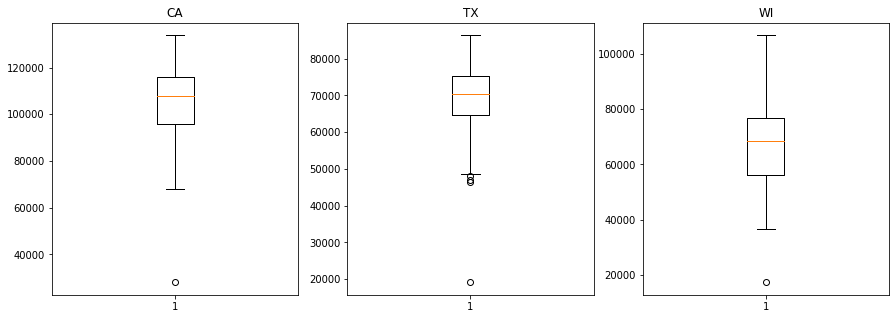

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].boxplot(sales_state_week["CA"])
ax[1].boxplot(sales_state_week["TX"])
ax[2].boxplot(sales_state_week["WI"])
ax[0].set_title("CA")
ax[1].set_title("TX")
ax[2].set_title("WI")
plt.show()

In [ ]:
# get rid of the incomplete first week and first month outlier data point
sales_state_week = sales_state_week[1:]
sales_state_month = sales_state_month[1:]

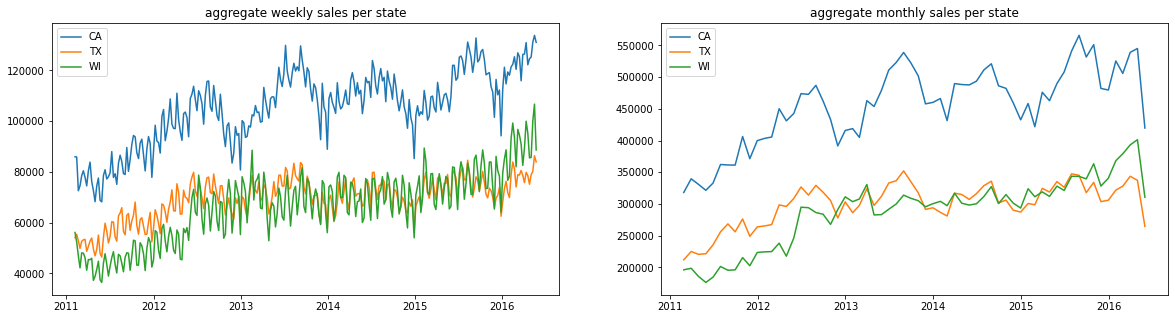

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].plot(sales_state_week.index.values, sales_state_week["CA"], label="CA")
ax[0].plot(sales_state_week.index.values, sales_state_week["TX"], label="TX")
ax[0].plot(sales_state_week.index.values, sales_state_week["WI"], label="WI")
ax[0].set_title("aggregate weekly sales per state")
ax[0].legend()
ax[1].plot(sales_state_month.index.values, sales_state_month["CA"], label="CA")
ax[1].plot(sales_state_month.index.values, sales_state_month["TX"], label="TX")
ax[1].plot(sales_state_month.index.values, sales_state_month["WI"], label="WI")
ax[1].set_title("aggregate monthly sales per state")
ax[1].legend()
# Apparently, all three states have an increasing trend of weekly & monthly sales across these six years; stores located in CA always
# have the highest sales, while WI-based stores' sales increase faster than those located in TX.  

# ARIMA / SARIMA Model

p-value: 0.28095554511061666
p-value: 0.0009125888627135505


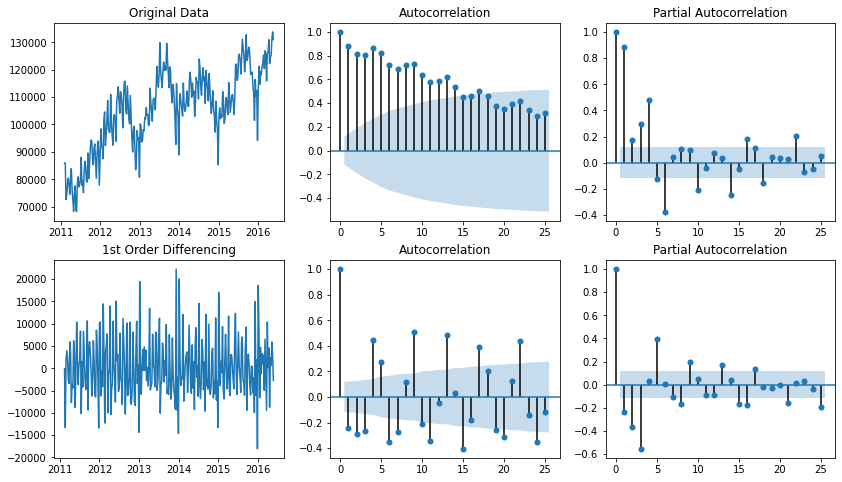

In [ ]:
# Using ARIMA/SARIMA model to fit CA-state sales data
# First step, determine the order of the differencing "d" by using ADF test
df = sales_state_week["CA"]

fig, ax = plt.subplots(2,3, figsize=(14,8))
ax[0,0].plot(df.dropna())
ax[0,0].set_title("Original Data")
plot_acf(df, ax=ax[0,1]);
plot_pacf(df, ax=ax[0,2]);
ax[1,0].plot(df.diff().dropna())
ax[1,0].set_title("1st Order Differencing")
plot_acf(df.diff().dropna(), ax=ax[1,1]);
plot_pacf(df.diff().dropna(), ax=ax[1,2]);

print("p-value:", adfuller(df.dropna())[1])
print("p-value:", adfuller(df.diff().dropna())[1])
# Based on the p-values, we can conclude that d=1 because p-value for first order differencing is <0.005; Given the ACF and PACF plots, 
# we can guess p=3, q=2

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                     CA   No. Observations:                  267
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2651.387
Date:                Mon, 12 Dec 2022   AIC                           5312.775
Time:                        15:33:31   BIC                           5330.692
Sample:                    02-06-2011   HQIC                          5319.973
                         - 03-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2509      0.002    100.853      0.000       0.246       0.256
ar.L2         -0.9975      0.003   -386.806      0.000      -1.003      -0.992
ma.L1         -0.2707      0.019    -14.008      0.0

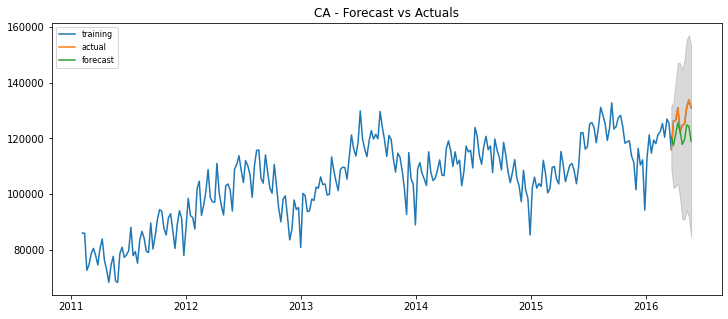

MAE: 6429.174513458912
RMSE: 7092.998573638701
RMSE divided by 100000: 0.07092998573638701
Range Normalized RMSE: 53.02889342996944
Mean Normalized RMSE: 19.92300576364788


In [ ]:
# Train-test split, we want to forecast on last 10-week sales
train = sales_state_week[:267]["CA"]
test = sales_state_week[267:]["CA"]

# Build model
arima_model = sm.tsa.arima.ARIMA(train, order = (2,1,2))
model_fit = arima_model.fit()
print(model_fit.summary())
#model_fit.plot_predict(dynamic=False);

# Predict for next 10-week sales and plot it
forecast = model_fit.get_forecast(10, alpha=0.05)
prediction_CA = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)
lower, upper = conf.iloc[:,0], conf.iloc[:,1]
plt.figure(figsize=(12,5))
plt.plot(sales_state_week["CA"], label='training')
plt.plot(test, label='actual')
plt.plot(test.index, prediction_CA, label='forecast')
plt.fill_between(test.index, lower, upper, color='k', alpha=.15)
plt.title('CA - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Compute forecast accuracy
print("MAE:", np.mean(np.abs(prediction_CA - test.values)))
print("RMSE:", np.mean((prediction_CA - test.values)**2)**.5)
print("RMSE divided by 100000:", np.sqrt(mean_squared_error(test.values, prediction_CA))/100000)
print("Range Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_CA) / (max(test.values) - min(test.values))))
print("Mean Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_CA) / (np.mean(test.values))))

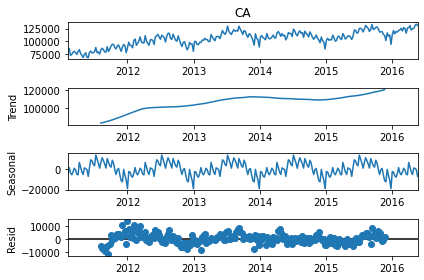

In [ ]:
# SARIMA model, because it has a seasonality according to ACF plot
decomp = seasonal_decompose(df, model="additive")
decomp.plot()
plt.show()

# Determine the order of SARIMA model
print("p-value:", adfuller(decomp.seasonal.dropna())[1])
print("p-value:", adfuller(decomp.seasonal.diff().dropna())[1]) # again the order of differencing is 1

p, P = range(0, 4, 1), range(0, 4, 1)
d, D = 1, 1
q, Q = range(0, 4, 1), range(0, 4, 1)

s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMA(parameters_list, 1, 1, 4, sales_state_week[:267]["CA"])
result_df

p-value: 0.0007313585743835135
p-value: 0.002799368559026261


  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 0, 2)",5246.455203
1,"(1, 0, 3, 3)",5262.469670
2,"(0, 1, 3, 3)",5263.779157
3,"(2, 1, 3, 3)",5264.555264
4,"(1, 3, 3, 3)",5267.466938
...,...,...
249,"(0, 0, 3, 0)",5380.704138
250,"(0, 0, 0, 1)",5384.311077
251,"(0, 0, 2, 0)",5385.648546
252,"(0, 0, 1, 0)",5386.359220


                                      SARIMAX Results                                       
Dep. Variable:                                   CA   No. Observations:                  267
Model:             SARIMAX(1, 1, 0)x(3, 1, [1], 12)   Log Likelihood               -2622.458
Date:                              Mon, 12 Dec 2022   AIC                           5256.916
Time:                                      15:43:53   BIC                           5278.140
Sample:                                  02-06-2011   HQIC                          5265.454
                                       - 03-13-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3172      0.095     -3.328      0.001      -0.504      -0.130
ar.S.L12      -0.51

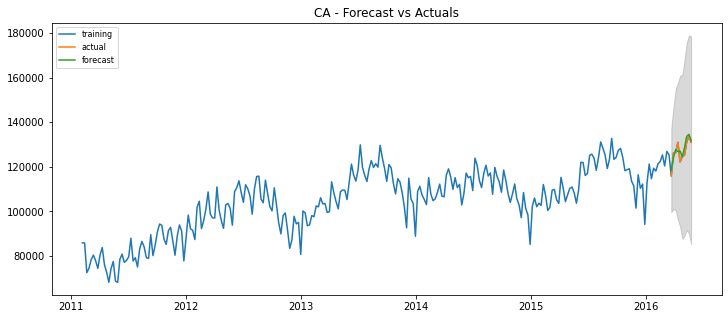

MAE: 2238.2173766029155
RMSE: 2670.77328066291
RMSE divided by 100000: 0.0267077328066291
Range Normalized RMSE: 19.967317095233565
Mean Normalized RMSE: 7.501740048531736


In [ ]:
best_model_fit = SARIMAX(train, order=(1,1,0), seasonal_order=(3,1,1,12)).fit(dis=-1)
print(best_model_fit.summary())
forecast = best_model_fit.get_forecast(10, alpha=0.05)
prediction_CA_SARIMA = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)
lower, upper = conf.iloc[:,0], conf.iloc[:,1]
plt.figure(figsize=(12,5))
plt.plot(sales_state_week["CA"], label='training')
plt.plot(test, label='actual')
plt.plot(test.index, prediction_CA_SARIMA, label='forecast')
plt.fill_between(test.index, lower, upper, color='k', alpha=.15)
plt.title('CA - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Compute forecast accuracy
print("MAE:", np.mean(np.abs(prediction_CA_SARIMA - test.values)))
print("RMSE:", np.mean((prediction_CA_SARIMA - test.values)**2)**.5)
print("RMSE divided by 100000:", np.sqrt(mean_squared_error(test.values, prediction_CA_SARIMA))/100000)
print("Range Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_CA_SARIMA) / (max(test.values) - min(test.values))))
print("Mean Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_CA_SARIMA) / (np.mean(test.values))))

p-value: 0.05762261810317125
p-value: 0.00040373532702640336


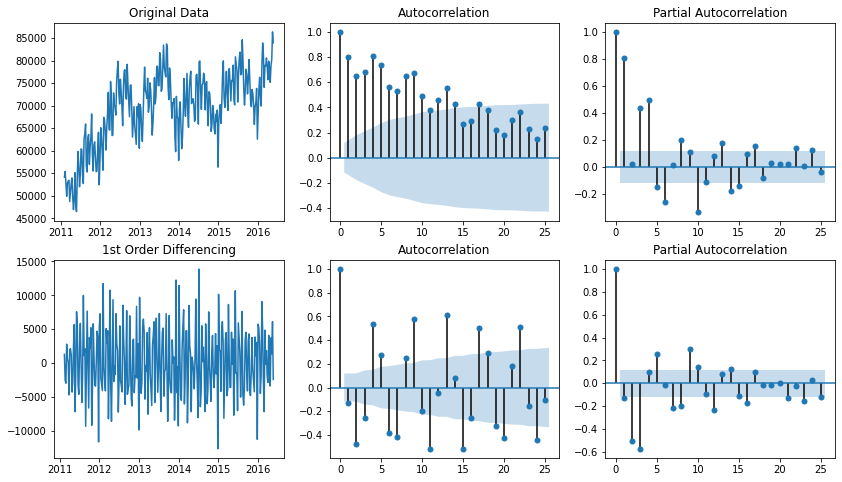

In [ ]:
# Using ARIMA/SARIMA model to fit TX-state sales data
# First step, determine the order of the differencing "d" by using ADF test
df = sales_state_week["TX"]

fig, ax = plt.subplots(2,3, figsize=(14,8))
ax[0,0].plot(df.dropna())
ax[0,0].set_title("Original Data")
plot_acf(df, ax=ax[0,1]);
plot_pacf(df, ax=ax[0,2]);
ax[1,0].plot(df.diff().dropna())
ax[1,0].set_title("1st Order Differencing")
plot_acf(df.diff().dropna(), ax=ax[1,1]);
plot_pacf(df.diff().dropna(), ax=ax[1,2]);

print("p-value:", adfuller(df.dropna())[1])
print("p-value:", adfuller(df.diff().dropna())[1])
# Based on the p-values, we can conclude that d=1 because p-value for first order differencing is <0.005; Given the ACF and PACF plots, 
# we can guess p=2, q=2

                               SARIMAX Results                                
Dep. Variable:                     TX   No. Observations:                  267
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2523.230
Date:                Mon, 12 Dec 2022   AIC                           5058.460
Time:                        15:46:29   BIC                           5079.961
Sample:                    02-06-2011   HQIC                          5067.098
                         - 03-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0314      0.037     -0.844      0.398      -0.104       0.041
ar.L2         -0.9287      0.010    -91.115      0.000      -0.949      -0.909
ar.L3         -0.2823      0.036     -7.740      0.0

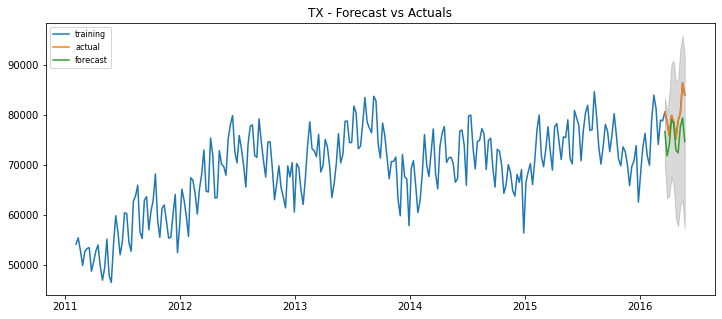

MAE: 4160.994839525959
RMSE: 5070.346367960961
RMSE divided by 100000: 0.050703463679609616
Range Normalized RMSE: 47.91026982351535
Mean Normalized RMSE: 17.949990042360415


In [ ]:
# Train-test split, we want to forecast on last 10-week sales
train = sales_state_week[:267]["TX"]
test = sales_state_week[267:]["TX"]

# Build model
arima_model = sm.tsa.arima.ARIMA(train, order = (3,1,2))
model_fit = arima_model.fit()
print(model_fit.summary())
#model_fit.plot_predict(dynamic=False);

# Predict for next 10-week sales and plot it
forecast = model_fit.get_forecast(10, alpha=0.05)
prediction_TX = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)
lower, upper = conf.iloc[:,0], conf.iloc[:,1]
plt.figure(figsize=(12,5))
plt.plot(sales_state_week["TX"], label='training')
plt.plot(test, label='actual')
plt.plot(test.index, prediction_TX, label='forecast')
plt.fill_between(test.index, lower, upper, color='k', alpha=.15)
plt.title('TX - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Compute forecast accuracy
print("MAE:", np.mean(np.abs(prediction_TX - test.values)))
print("RMSE:", np.mean((prediction_TX - test.values)**2)**.5)
print("RMSE divided by 100000:", np.sqrt(mean_squared_error(test.values, prediction_TX))/100000)
print("Range Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_TX) / (max(test.values) - min(test.values))))
print("Mean Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_TX) / (np.mean(test.values))))

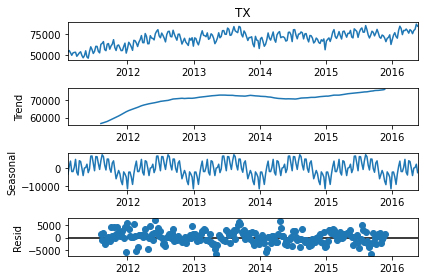

p-value: 0.0017308187029452804
p-value: 0.00010385056884732369


  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 2, 0, 1)",4963.093924
1,"(3, 2, 0, 2)",4965.255184
2,"(3, 3, 0, 1)",4968.962823
3,"(3, 2, 1, 1)",4969.451131
4,"(3, 2, 2, 2)",4969.974623
...,...,...
236,"(0, 1, 0, 0)",5222.449010
237,"(1, 0, 1, 0)",5233.294744
238,"(0, 0, 1, 0)",5233.653397
239,"(1, 0, 0, 0)",5244.476807


In [ ]:
# SARIMA model, because it has a seasonality according to ACF plot
decomp = seasonal_decompose(df, model="additive")
decomp.plot()
plt.show()

# Determine the order of SARIMA model
print("p-value:", adfuller(decomp.seasonal.dropna())[1])
print("p-value:", adfuller(decomp.seasonal.diff().dropna())[1]) # again the order of differencing is 1

p, P = range(0, 4, 1), range(0, 4, 1)
d, D = 1, 1
q, Q = range(0, 4, 1), range(0, 4, 1)

s = 52
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMA(parameters_list, 1, 1, 12, sales_state_week[:267]["TX"])
result_df

                                      SARIMAX Results                                       
Dep. Variable:                                   TX   No. Observations:                  267
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2474.547
Date:                              Mon, 12 Dec 2022   AIC                           4963.094
Time:                                      15:55:54   BIC                           4987.855
Sample:                                  02-06-2011   HQIC                          4973.055
                                       - 03-13-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0499      0.090     -0.554      0.580      -0.226       0.127
ar.L2         -0.92

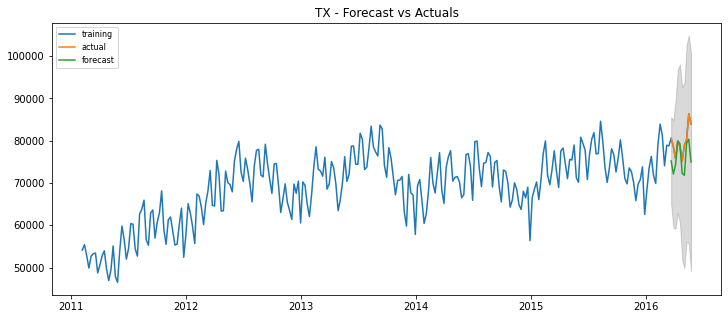

MAE: 3997.2812115125444
RMSE: 4999.929220359075
RMSE divided by 100000: 0.04999929220359075
Range Normalized RMSE: 47.244890321411354
Mean Normalized RMSE: 17.700699953175917


In [ ]:
best_model_fit = SARIMAX(train, order=(3,1,2), seasonal_order=(0,1,1,12)).fit(dis=-1)
print(best_model_fit.summary())
forecast = best_model_fit.get_forecast(10, alpha=0.05)
prediction_TX_SARIMA = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)
lower, upper = conf.iloc[:,0], conf.iloc[:,1]
plt.figure(figsize=(12,5))
plt.plot(sales_state_week["TX"], label='training')
plt.plot(test, label='actual')
plt.plot(test.index, prediction_TX_SARIMA, label='forecast')
plt.fill_between(test.index, lower, upper, color='k', alpha=.15)
plt.title('TX - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Compute forecast accuracy
print("MAE:", np.mean(np.abs(prediction_TX_SARIMA - test.values)))
print("RMSE:", np.mean((prediction_TX_SARIMA - test.values)**2)**.5)
print("RMSE divided by 100000:", np.sqrt(mean_squared_error(test.values, prediction_TX_SARIMA))/100000)
print("Range Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_TX_SARIMA) / (max(test.values) - min(test.values))))
print("Mean Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_TX_SARIMA) / (np.mean(test.values))))

p-value: 0.8490689737451886
p-value: 8.988147755360666e-08


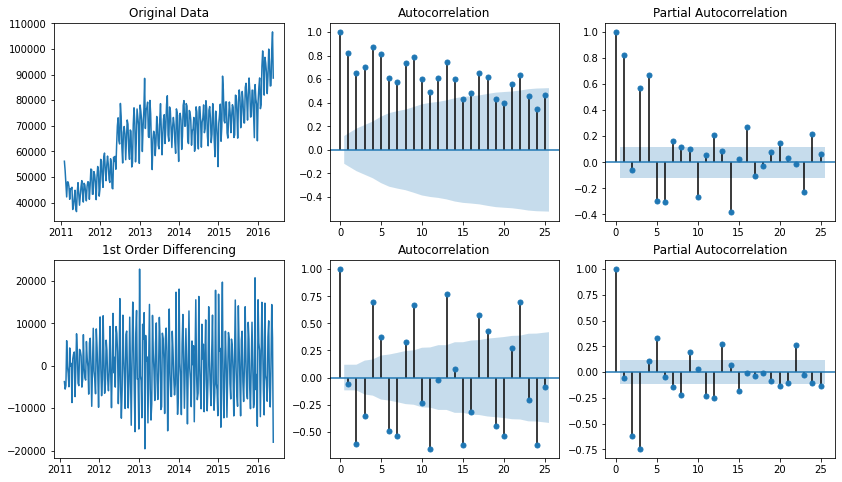

In [ ]:
# Using ARIMA/SARIMA model to fit WI-state sales data
# First step, determine the order of the differencing "d" by using ADF test
df = sales_state_week["WI"]

fig, ax = plt.subplots(2,3, figsize=(14,8))
ax[0,0].plot(df.dropna())
ax[0,0].set_title("Original Data")
plot_acf(df, ax=ax[0,1]);
plot_pacf(df, ax=ax[0,2]);
ax[1,0].plot(df.diff().dropna())
ax[1,0].set_title("1st Order Differencing")
plot_acf(df.diff().dropna(), ax=ax[1,1]);
plot_pacf(df.diff().dropna(), ax=ax[1,2]);

print("p-value:", adfuller(df.dropna())[1])
print("p-value:", adfuller(df.diff().dropna())[1])
# Based on the p-values, we can conclude that d=1 because p-value for first order differencing is <0.005; Given the ACF and PACF plots, 
# we can guess p=3, q=3

                               SARIMAX Results                                
Dep. Variable:                     WI   No. Observations:                  267
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -2582.741
Date:                Mon, 12 Dec 2022   AIC                           5177.481
Time:                        15:58:14   BIC                           5198.982
Sample:                    02-06-2011   HQIC                          5186.119
                         - 03-13-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2025      0.033     -6.091      0.000      -0.268      -0.137
ar.L2         -0.8842      0.009   -103.140      0.000      -0.901      -0.867
ar.L3         -0.4509      0.033    -13.764      0.0

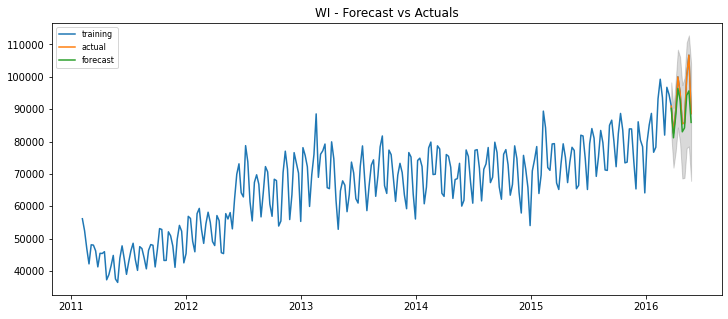

MAE: 3330.6393176622296
RMSE: 4425.692630116915
RMSE divided by 100000: 0.044256926301169154
Range Normalized RMSE: 28.50247957681943
Mean Normalized RMSE: 14.55261038211704


In [ ]:
# Train-test split, we want to forecast on last 10-week sales
train = sales_state_week[:267]["WI"]
test = sales_state_week[267:]["WI"]

# Build model
arima_model = sm.tsa.arima.ARIMA(train, order = (3,1,2))
model_fit = arima_model.fit()
print(model_fit.summary())
#model_fit.plot_predict(dynamic=False);

# Predict for next 10-week sales and plot it
forecast = model_fit.get_forecast(10, alpha=0.05)
prediction_WI = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)
lower, upper = conf.iloc[:,0], conf.iloc[:,1]
plt.figure(figsize=(12,5))
plt.plot(sales_state_week["WI"], label='training')
plt.plot(test, label='actual')
plt.plot(test.index, prediction_WI, label='forecast')
plt.fill_between(test.index, lower, upper, color='k', alpha=.15)
plt.title('WI - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Compute forecast accuracy
print("MAE:", np.mean(np.abs(prediction_WI - test.values)))
print("RMSE:", np.mean((prediction_WI - test.values)**2)**.5)
print("RMSE divided by 100000:", np.sqrt(mean_squared_error(test.values, prediction_WI))/100000)
print("Range Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_WI) / (max(test.values) - min(test.values))))
print("Mean Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_WI) / (np.mean(test.values))))

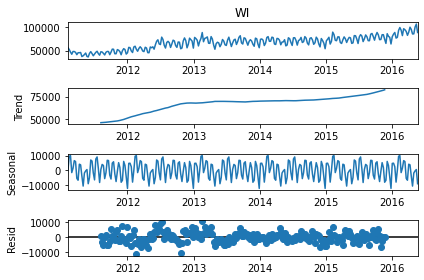

p-value: 1.808389075611751e-09
p-value: 7.035724654198332e-14


  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(3, 3, 1, 0)",5233.868464
1,"(3, 3, 1, 2)",5236.916422
2,"(3, 3, 2, 1)",5238.843943
3,"(3, 3, 0, 1)",5242.743745
4,"(3, 3, 2, 3)",5243.084051
...,...,...
251,"(0, 1, 0, 0)",6509.007216
252,"(0, 0, 0, 3)",6525.024521
253,"(0, 0, 0, 2)",6529.441994
254,"(0, 0, 0, 1)",6547.171699


In [ ]:
# SARIMA model, because it has a seasonality according to ACF plot
decomp = seasonal_decompose(df, model="additive")
decomp.plot()
plt.show()

# Determine the order of SARIMA model
print("p-value:", adfuller(decomp.seasonal.dropna())[1])
print("p-value:", adfuller(decomp.seasonal.diff().dropna())[1]) # again the order of differencing is 1

p, P = range(0, 4, 1), range(0, 4, 1)
d, D = 0, 0
q, Q = range(0, 4, 1), range(0, 4, 1)

s = 52
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMA(parameters_list, 0, 0, 12, sales_state_week[:267]["WI"])
result_df

                                     SARIMAX Results                                      
Dep. Variable:                                 WI   No. Observations:                  267
Model:             SARIMAX(3, 1, 2)x(1, 0, [], 4)   Log Likelihood               -2581.320
Date:                            Mon, 12 Dec 2022   AIC                           5176.640
Time:                                    16:24:46   BIC                           5201.724
Sample:                                02-06-2011   HQIC                          5186.717
                                     - 03-13-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1729      0.033     -5.205      0.000      -0.238      -0.108
ar.L2         -0.8921      0.009   

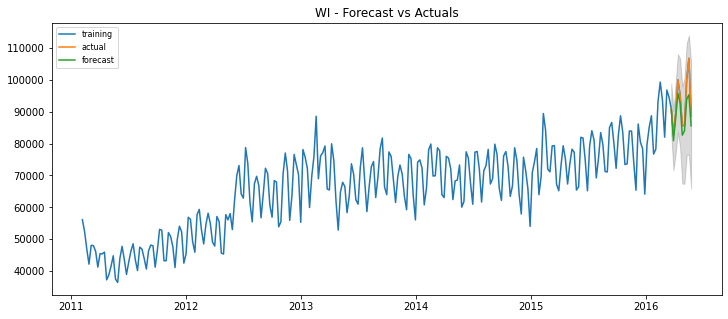

MAE: 3539.595654135787
RMSE: 4683.101600443715
RMSE divided by 100000: 0.04683101600443715
Range Normalized RMSE: 30.160252615485227
Mean Normalized RMSE: 15.39902534291582


In [ ]:
best_model_fit = SARIMAX(train, order=(3,1,2), seasonal_order=(1,0,0,4)).fit(dis=-1)
print(best_model_fit.summary())
forecast = best_model_fit.get_forecast(10, alpha=0.05)
prediction_WI_SARIMA = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)
lower, upper = conf.iloc[:,0], conf.iloc[:,1]
plt.figure(figsize=(12,5))
plt.plot(sales_state_week["WI"], label='training')
plt.plot(test, label='actual')
plt.plot(test.index, prediction_WI_SARIMA, label='forecast')
plt.fill_between(test.index, lower, upper, color='k', alpha=.15)
plt.title('WI - Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Compute forecast accuracy
print("MAE:", np.mean(np.abs(prediction_WI_SARIMA - test.values)))
print("RMSE:", np.mean((prediction_WI_SARIMA - test.values)**2)**.5)
print("RMSE divided by 100000:", np.sqrt(mean_squared_error(test.values, prediction_WI_SARIMA))/100000)
print("Range Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_WI_SARIMA) / (max(test.values) - min(test.values))))
print("Mean Normalized RMSE:", np.sqrt(mean_squared_error(test.values, prediction_WI_SARIMA) / (np.mean(test.values))))

MAE: 7018.049889742385
RMSE: 8289.037980684063
RMSE divided by 100000: 0.08289037980684062
Range Normalized RMSE: 40.663329682804196
Mean Normalized RMSE: 15.158237587952282


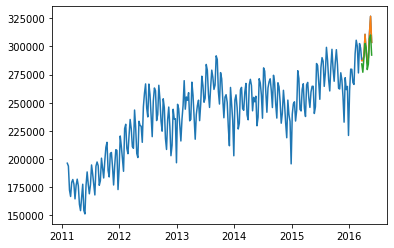

In [ ]:
agg_prediction = prediction_CA_SARIMA + prediction_TX_SARIMA + prediction_WI_SARIMA
true_y = sales_state_week["CA"][267:]+sales_state_week["TX"][267:]+sales_state_week["WI"][267:]
plt.plot(sales_state_week["CA"]+sales_state_week["TX"]+sales_state_week["WI"], label = 'training')
plt.plot(true_y, label='actual')
plt.plot(test.index, agg_prediction, label='forecast')
print("MAE:", np.mean(np.abs(agg_prediction - true_y)))
print("RMSE:", np.mean((agg_prediction - true_y)**2)**.5)
print("RMSE divided by 100000:", np.sqrt(mean_squared_error(agg_prediction, true_y))/100000)
print("Range Normalized RMSE:", np.sqrt(mean_squared_error(agg_prediction, true_y) / (max(true_y) - min(true_y))))
print("Mean Normalized RMSE:", np.sqrt(mean_squared_error(agg_prediction, true_y) / (np.mean(true_y))))

# GP-based Model

In [ ]:
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__k2__length_scale is close to

316**2 * RBF(length_scale=50) + 316**2 * RBF(length_scale=300) * ExpSineSquared(length_scale=3.55, periodicity=48) + 316**2 * RationalQuadratic(alpha=5.82, length_scale=1.02e-05) + WhiteKernel(noise_level=1.29)
rmse = 6644.6633565991415


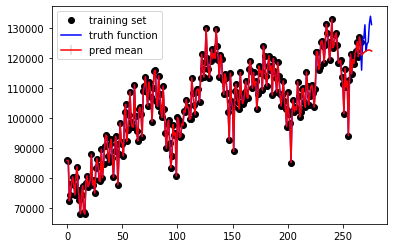

In [ ]:
all_X, true_y = np.arange(0,277,1), sales_state_week["CA"].values
X_train, y_train =  all_X[:267], true_y[:267]

long_term_trend_kernel = 300**2 * RBF(length_scale=50.0, length_scale_bounds="fixed")
seasonal_kernel = (5**2 * RBF(length_scale=200.0, length_scale_bounds = (0, 300)) \
                   * ExpSineSquared(length_scale=1, periodicity=48.0, periodicity_bounds="fixed"))
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))
kernel = long_term_trend_kernel + seasonal_kernel+irregularities_kernel + noise_kernel
# kernel = 33**2 * RBF(length_scale = 50) * ExpSineSquared(length_scale=0.6, periodicity=12, 
                                                    #  length_scale_bounds = (0, 300),
                                                    #  periodicity_bounds= (0, 300)) + WhiteKernel(noise_level = 1)
# fit the model
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

# predict for all_X
mus, sigmas = gp.predict(all_X.reshape(-1, 1), return_std=True)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[267:], true_y[267:]))))
plot_gp(all_X, mus, sigmas, X_train, y_train, true_y=true_y)
plt.show()
prediction_CA_gp = mus[-10:]

316**2 * RBF(length_scale=255) + 316**2 * RBF(length_scale=0.0946) * ExpSineSquared(length_scale=0.997, periodicity=52) + 0.504**2 * RationalQuadratic(alpha=0.99, length_scale=0.989) + WhiteKernel(noise_level=0.01)
rmse = 9920.381503175553


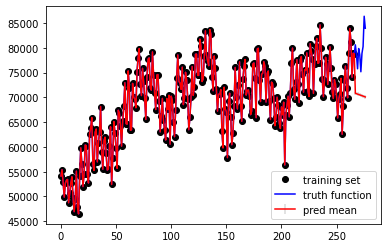

In [ ]:
all_X, true_y = np.arange(0,277,1), sales_state_week["TX"].values
X_train, y_train =  all_X[:267], true_y[:267]

long_term_trend_kernel = 300**2 * RBF(length_scale=50.0, length_scale_bounds=(0,300))
seasonal_kernel = (5**2 * RBF(length_scale=200.0, length_scale_bounds = (0, 300)) \
                   * ExpSineSquared(length_scale=1, periodicity=52.0, periodicity_bounds="fixed"))
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = WhiteKernel(noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5))
kernel = long_term_trend_kernel + seasonal_kernel+irregularities_kernel + noise_kernel

# kernel_yearly =3**2 * RBF(length_scale = 200) * ExpSineSquared(length_scale=0.9, periodicity=52, 
#                                                      length_scale_bounds = (0, 350),
#                                                      periodicity_bounds= (48, 55)) + WhiteKernel(noise_level = 1)
# kernel_quarterly =3**2 * RBF(length_scale = 200) * ExpSineSquared(length_scale=0.9, periodicity=13, 
#                                                      length_scale_bounds = (0, 350),
#                                                      periodicity_bounds= (10, 15)) + WhiteKernel(noise_level = 1)    
# kernel_monthly =3**2 * RBF(length_scale = 200) * ExpSineSquared(length_scale=0.9, periodicity=4, 
#                                                      length_scale_bounds = (0, 350),
#                                                      periodicity_bounds= (3, 5)) + WhiteKernel(noise_level = 1)    

# kernel = kernel_yearly * kernel_quarterly
# fit the model
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

# predict for all_X
mus, sigmas = gp.predict(all_X.reshape(-1, 1), return_std=True)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[267:], true_y[267:]))))
plot_gp(all_X, mus, sigmas, X_train, y_train, true_y=true_y)
plt.show()
prediction_TX_gp = mus[-10:]

/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:335: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__k1__k1__constant_value is close to the specified up

316**2 * RBF(length_scale=49) * ExpSineSquared(length_scale=342, periodicity=49) + WhiteKernel(noise_level=1e+05) + 316**2 * RBF(length_scale=1e+05) * ExpSineSquared(length_scale=350, periodicity=4) + WhiteKernel(noise_level=1e+05)
rmse = 14658.212059267566


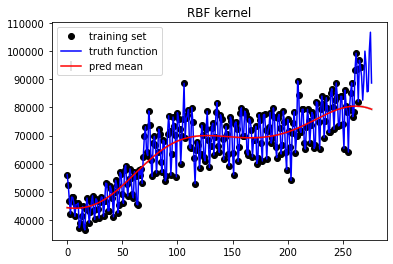

In [ ]:
all_X, true_y = np.arange(0,277,1), sales_state_week["WI"].values
X_train, y_train =  all_X[:267], true_y[:267]

kernel_yearly =300**2 * RBF(length_scale = 200) * ExpSineSquared(length_scale=4, periodicity=49, 
                                                     length_scale_bounds = (0, 350),
                                                     periodicity_bounds="fixed") + WhiteKernel(noise_level = 1)
kernel_monthly =300**2 * RBF(length_scale = 200) * ExpSineSquared(length_scale=4, periodicity=4, 
                                                     length_scale_bounds = (0, 350),
                                                     periodicity_bounds="fixed") + WhiteKernel(noise_level = 1)                                             
kernel = kernel_yearly + kernel_monthly

# fit the model
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
print(gp.kernel_)

# predict for all_X
mus, sigmas = gp.predict(all_X.reshape(-1, 1), return_std=True)
print("rmse = {0}".format(np.sqrt(mean_squared_error(mus[267:], true_y[267:]))))
plot_gp(all_X, mus, sigmas, X_train, y_train, true_y=true_y)
plt.title("RBF kernel")
plt.show()
prediction_WI_gp = mus[-10:]

MAE: 23616.709665873535
RMSE: 26894.468512530188
RMSE divided by 100000: 0.2689446851253019
Range Normalized RMSE: 131.93553248486373
Mean Normalized RMSE: 49.18215412507865


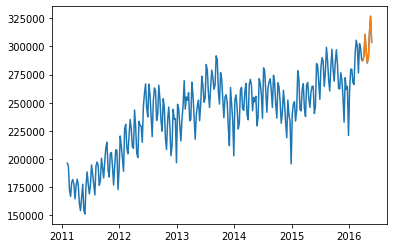

In [ ]:
agg_prediction = (prediction_CA_gp + prediction_TX_gp + prediction_WI_gp).T[0]
true_y = sales_state_week["CA"][267:]+sales_state_week["TX"][267:]+sales_state_week["WI"][267:]
plt.plot(sales_state_week["CA"]+sales_state_week["TX"]+sales_state_week["WI"], label = 'training')
plt.plot(true_y, label='actual')
#plt.plot(test.index, agg_prediction, label='forecast')
print("MAE:", np.mean(np.abs(agg_prediction - true_y)))
print("RMSE:", np.mean((agg_prediction - true_y)**2)**.5)
print("RMSE divided by 100000:", np.sqrt(mean_squared_error(agg_prediction, true_y))/100000)
print("Range Normalized RMSE:", np.sqrt(mean_squared_error(agg_prediction, true_y) / (max(true_y) - min(true_y))))
print("Mean Normalized RMSE:", np.sqrt(mean_squared_error(agg_prediction, true_y) / (np.mean(true_y))))